In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import callbacks

In [2]:
train = pd.read_csv("data/train.csv", index_col=0)
test = pd.read_csv("data/test.csv", index_col=0)

y = train['target']
features = train.drop(['target'], axis=1)

In [3]:
object_cols = [col for col in features.columns if 'cat' in col]

X = features.copy()
X_test = test.copy()
ordinal_encoder = OrdinalEncoder()
X[object_cols] = ordinal_encoder.fit_transform(features[object_cols])
X_test[object_cols] = ordinal_encoder.transform(test[object_cols])

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=0)

In [5]:
sc=preprocessing.StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_valid_sc = sc.transform(X_valid)
X_test_sc = sc.transform(X_test)

In [6]:
def lr_schedul(epoch):
    x = 0.01
    if epoch >= 5:
        x = 0.005
    if epoch >= 10:
        x = 0.001
    if epoch >= 15:
        x = 0.001
    if epoch >= 20:
        x = 0.0005
    if epoch >= 30:
        x = 0.0001
    if epoch >= 60:
        x = 0.00001        
    return x

lr_decay = LearningRateScheduler(
    lr_schedul,
    verbose=1,
)

In [7]:
model = Sequential()
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))

model.compile(Adam(lr=1e-3), loss="mean_squared_error")
early_stopping_cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True) 

history = model.fit(X_train_sc, y_train, batch_size=256, epochs=200,verbose=1, validation_data=(X_valid_sc, y_valid), 
                    callbacks=[lr_decay, early_stopping_cb], shuffle=True)
model.summary()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/70

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
997/997 [==============================] - 5s 5ms/step - loss: 1.2917 - val_loss: 0.5808
Epoch 2/70

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
997/997 [==============================] - 5s 5ms/step - loss: 0.6704 - val_loss: 0.5483
Epoch 3/70

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
997/997 [==============================] - 5s 5ms/step - loss: 0.6430 - val_loss: 0.5468
Epoch 4/70

Epoch 00004: LearningRateScheduler setting learning rate to 0.01.
997/997 [==============================] - 5s 5ms/step - loss: 0.6175 - val_loss: 0.5471
Epoch 5/70

Epoch 00005: LearningRateScheduler setting learning rate to 0.01.
997/997 [==============================] - 5s 5ms/step - loss: 0.5992 - val_loss: 0.5475
Epoch 6/70

Epoch 00006: LearningRateScheduler setting learning rate to 0.005.
997/997 [==============================] - 5s 5ms/step - loss: 0.5817 - val_loss: 0.54

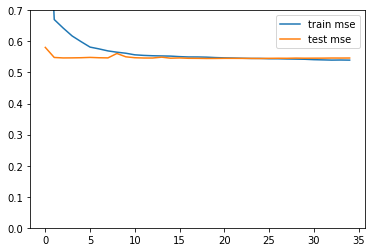

In [8]:
train_acc = history.history['loss']
test_acc = history.history['val_loss']
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train mse')
plt.plot(x, test_acc, label = 'test mse')
plt.ylim(0, 0.7)
plt.legend()
plt.show()

In [9]:
predictions = model.predict(X_test_sc)
predictions = predictions.flatten()

In [10]:
output = pd.DataFrame({'Id': X_test.index,
                       'target': predictions})
output.to_csv('submission6.csv', index=False)